In [ ]:
install.packages("ggraph")
install.packages("igraph")
install.packages("tidyverse")

In [4]:
# Libraries
library(ggraph)
library(igraph)
library(tidyverse)
library(RColorBrewer)
library(geomtextpath)


Loading required package: ggplot2




Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::%--%()      masks igraph::%--%()
✖ dplyr::as_data_frame() masks tibble::as_data_frame(), igraph::as_data_frame()
✖ purrr::compose()       masks igraph::compose()
✖ tidyr::crossing()      masks igraph::crossing()
✖ dplyr::filt

In [78]:
# Define colors for different cell categories
color_map <- c(
  'immune adaptive' = 'lightgreen',
  'immune native' = 'lightblue',
  'immune both' = 'purple',
  'stromal' = '#D2B48C',
  'epithelial' = 'yellow',
  'tumoral' = 'red'
)

# Define cell categories
cell_categories <- list(
  'immune adaptive' = c('T cell CD8 activated', 'T cell CD4', 'B cell', 'B cell dividing', 'T cell regulatory', 'T cell CD8 effector memory',
                        'T cell CD8 activated', 'cDC2', 'T cell CD8 terminally exhausted', 'T cell CD4 dividing', 'T cell CD8 dividing', 'T cell CD8 naive'),
  'immune both' = c('Mast cell', 'myeloid dividing', 'pDC', 'DC mature', 'T cell NK-like', "Plasma cell", "Plasma cell dividing"),
  'immune native' = c('Monocyte classical', 'Monocyte non-classical', 'NK cell', 'Macrophage', 'Macrophage alveolar', 'NK cell dividing', 'Neutrophils', 'cDC1'),
  'stromal' = c('Fibroblast peribronchial', 'Fibroblast alveolar', 'Endothelial cell venous', 'Endothelial cell lymphatic',
                'Endothelial cell capillary', 'Smooth muscle cell', 'Pericyte', 'Fibroblast adventitial', 'stromal dividing'),
  'epithelial' = c('Alveolar cell type 1', 'Alveolar cell type 2', 'Ciliated', 'Club', 'transitional club/AT2', 'ROS1+ healthy epithelial'),
  'tumoral' = c('Tumor cells LUAD', 'Tumor LUAD_mixed', 'Tumor LUAD_transitional', 'Tumor LUAD_LUSC', 'Tumor LUAD_mitotic', 'Tumor LUAD_LUSC_mitotic', 'Tumor LUAD_mainly1')
)

cell_type_to_category <- unlist(lapply(names(cell_categories), function(category) {
  setNames(rep(category, length(cell_categories[[category]])), cell_categories[[category]])
}))

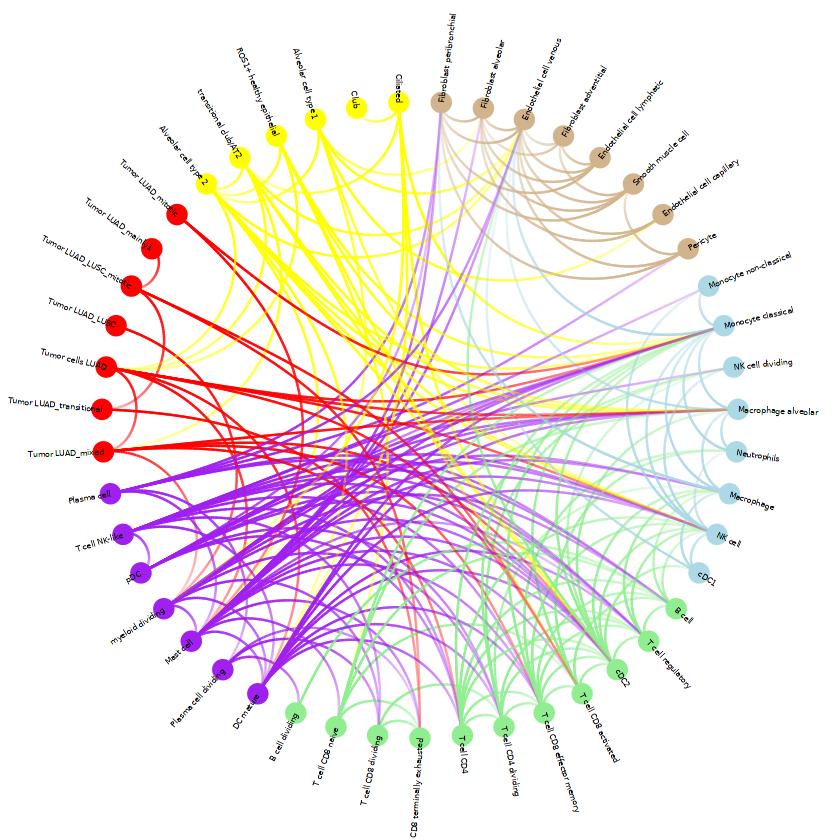

In [ ]:
net = read.csv('/root/host_home/luca/outputARACNE/netI-II_leiden.txt', sep = '\t', col.names = c('from', 'to', 'MI', 'pval'))

# Extract igraph from net
G <- igraph::graph_from_data_frame(net, directed = FALSE)



vertex_df <- as.data.frame(vertex_attr(G))
vertex_df$order <- 1:vcount(G)  # Preserve the original order

# Assign cell types and colors
vertex_df$category <- cell_type_to_category[vertex_df$name]
vertex_df$color <- color_map[vertex_df$category]

# Update the graph with the new attributes
V(G)$category <- vertex_df$category
V(G)$color <- vertex_df$color

# Order vertices by group
vertex_df <- vertex_df[order(vertex_df$color, vertex_df$order), ]
# Reorder the graph vertices
G <- permute(G, match(V(G)$name, vertex_df$name))

# Subset the graph to only include nodes with a certain category
# category_to_include <- 'tumoral'
# G <- induced_subgraph(G, V(G)$category == category_to_include)

# Create the layout with nodes in ordered positions
layout <- create_layout(G, layout = 'linear', circular = TRUE)

# Calculate the angle and horizontal adjustment for labels
layout <- layout %>%
  mutate(angle = 90 - 360 * (1:n()) / n(),
         hjust = ifelse(angle < -90 | angle > 90, 1, 0),
         angle = ifelse(angle < -90 | angle > 90, angle + 180, angle))

from <- match(as_edgelist(G)[,1], V(G)$name)
to <- match(as_edgelist(G)[,2], V(G)$name)

# Create a dataframe from get_con and add a color column
con_function <- get_con(from = from, to = to)
# con_df$color <- colorRampPalette(brewer.pal(9, "Set1"))(nrow(con_df))
con_df <- con_function(layout)

# Plot the graph
ggraph(layout) +
  # geom_conn_bundle(data = get_con(from = from, to = to), alpha=0.2, colour="skyblue", width=0.6, tension = 0.9) +
  # geom_conn_bundle(data = con_df, alpha=0.2, aes(colour = con_df$color), width=0.6, tension = 0.9) +
  geom_edge_arc(aes(color = node2.category, alpha = ..index..)) + # very important to observe edge_data <- get_edges()(layout) to see avialable columns
  scale_edge_color_manual(
    # limits = as.factor(layout$category),
    values = color_map
  ) +
  # geom_edge_link( aes(colour=after_scale(color))) +
  geom_node_point(aes(colour = category), size = 5) +
  scale_colour_manual(values = color_map) +
  geom_node_text(aes(label = name, angle = angle, hjust = hjust), size = 1.5, alpha=1.0) +
  # geom_textpath(data = arc_layout, aes(x = x, y = y, label = "Arc Text Example"), size = 3, color = "red", vjust = -1.15) +
  theme_void() +
  theme(
    legend.position="none",
    plot.margin=unit(c(0,0,0,0),"cm"),
  ) +
  expand_limits(x = c(-1.2, 1.2), y = c(-1.2, 1.2))

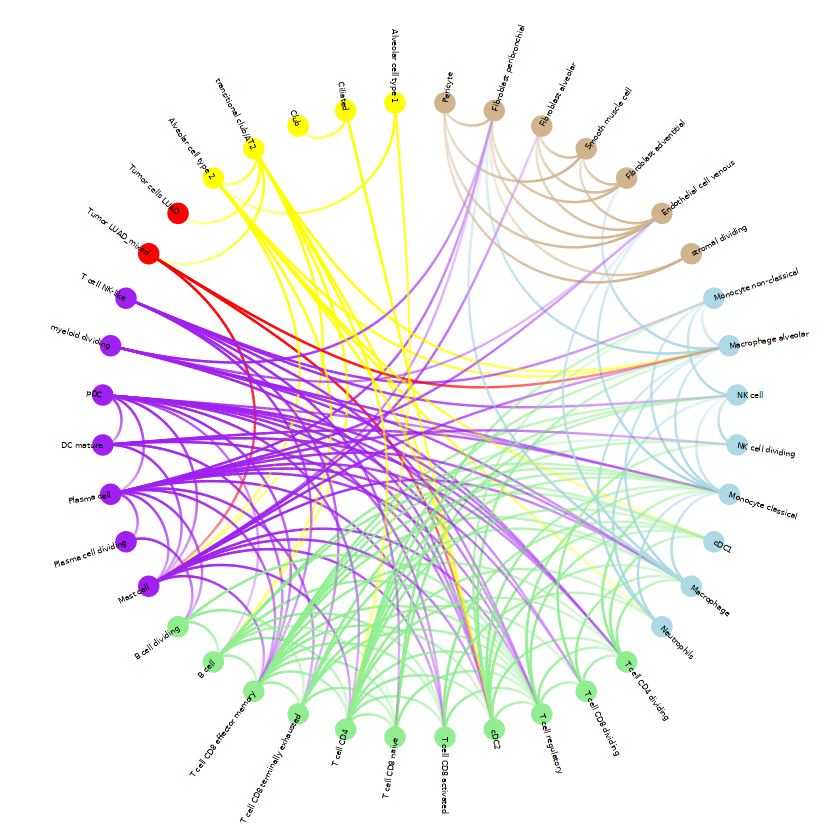

In [80]:
net = read.csv('/root/host_home/luca/outputARACNE/netIII-IV_leiden.txt', sep = '\t', col.names = c('from', 'to', 'MI', 'pval'))

# Extract igraph from net
G <- igraph::graph_from_data_frame(net, directed = FALSE)



vertex_df <- as.data.frame(vertex_attr(G))
vertex_df$order <- 1:vcount(G)  # Preserve the original order

# Assign cell types and colors
vertex_df$category <- cell_type_to_category[vertex_df$name]
vertex_df$color <- color_map[vertex_df$category]

# Update the graph with the new attributes
V(G)$category <- vertex_df$category
V(G)$color <- vertex_df$color

# Order vertices by group
vertex_df <- vertex_df[order(vertex_df$color, vertex_df$order), ]
# Reorder the graph vertices
G <- permute(G, match(V(G)$name, vertex_df$name))

# Subset the graph to only include nodes with a certain category
# category_to_include <- 'tumoral'
# G <- induced_subgraph(G, V(G)$category == category_to_include)

# Create the layout with nodes in ordered positions
layout <- create_layout(G, layout = 'linear', circular = TRUE)

# Calculate the angle and horizontal adjustment for labels
layout <- layout %>%
  mutate(angle = 90 - 360 * (1:n()) / n(),
         hjust = ifelse(angle < -90 | angle > 90, 1, 0),
         angle = ifelse(angle < -90 | angle > 90, angle + 180, angle))

from <- match(as_edgelist(G)[,1], V(G)$name)
to <- match(as_edgelist(G)[,2], V(G)$name)

# Create a dataframe from get_con and add a color column
con_function <- get_con(from = from, to = to)
# con_df$color <- colorRampPalette(brewer.pal(9, "Set1"))(nrow(con_df))
con_df <- con_function(layout)

# Plot the graph
ggraph(layout) +
  # geom_conn_bundle(data = get_con(from = from, to = to), alpha=0.2, colour="skyblue", width=0.6, tension = 0.9) +
  # geom_conn_bundle(data = con_df, alpha=0.2, aes(colour = con_df$color), width=0.6, tension = 0.9) +
  geom_edge_arc(aes(color = node2.category, alpha = ..index..)) + # very important to observe edge_data <- get_edges()(layout) to see avialable columns
  scale_edge_color_manual(
    # limits = as.factor(layout$category),
    values = color_map
  ) +
  # geom_edge_link( aes(colour=after_scale(color))) +
  geom_node_point(aes(colour = category), size = 5) +
  scale_colour_manual(values = color_map) +
  geom_node_text(aes(label = name, angle = angle, hjust = hjust), size = 1.5, alpha=1.0) +
  # geom_textpath(data = arc_layout, aes(x = x, y = y, label = "Arc Text Example"), size = 3, color = "red", vjust = -1.15) +
  theme_void() +
  theme(
    legend.position="none",
    plot.margin=unit(c(0,0,0,0),"cm"),
  ) +
  expand_limits(x = c(-1.2, 1.2), y = c(-1.2, 1.2))

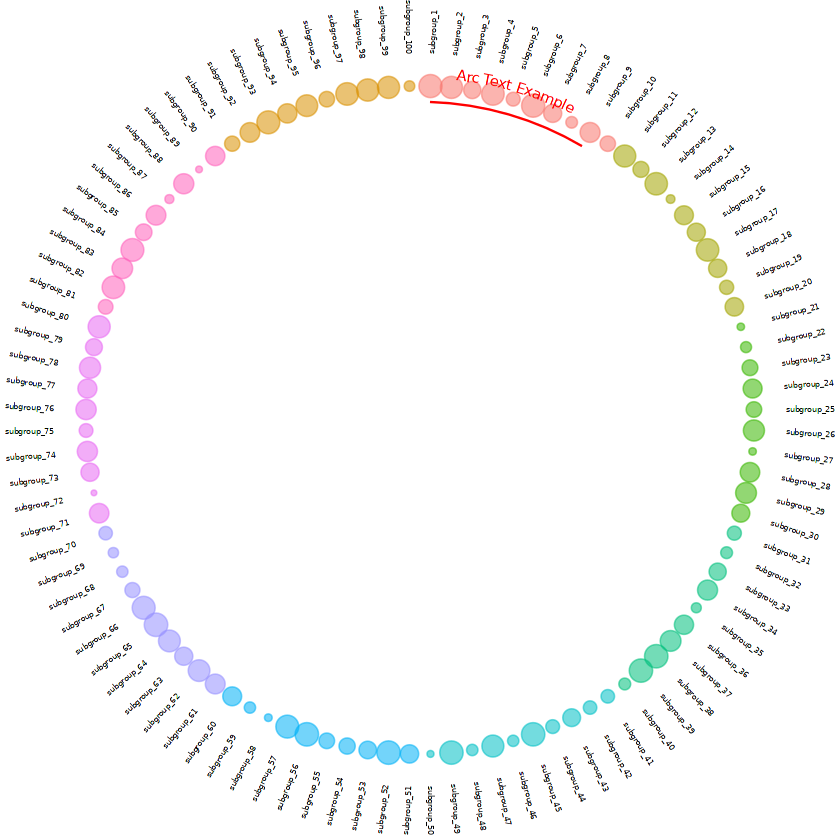

In [131]:


# Create a graph object
mygraph <- igraph::graph_from_data_frame( edges, vertices=vertices )
 
# The connection object must refer to the ids of the leaves:
from  <-  match( connect$from, vertices$name)
to  <-  match( connect$to, vertices$name)

layout <- create_layout(mygraph, layout = 'dendrogram', circular = TRUE)
arc_layout <- layout[layout$arc == TRUE, ]
# Basic usual argument
ggraph(mygraph, layout = 'dendrogram', circular = TRUE) + 
  geom_node_point(aes(filter = leaf, x = x*1.05, y=y*1.05, colour=group, size=value, alpha=0.2)) +
  geom_conn_bundle(data = get_con(from = from, to = to), alpha=0.2, colour="skyblue", width=0.9) +
  geom_node_text(aes(x = x*1.15, y=y*1.15, filter = leaf, label=name, angle = angle, hjust=hjust), size=1.5, alpha=1) +
  geom_textpath(data = arc_layout, aes(x = x, y = y, label = "Arc Text Example"), size = 3, color = "red", vjust = -1.15) +
  theme_void() +
  theme(
    legend.position="none",
    plot.margin=unit(c(0,0,0,0),"cm"),
  ) +
  expand_limits(x = c(-1.2, 1.2), y = c(-1.2, 1.2))

